# CNN model

## Notebook set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

# Silence tensorflow, except for errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Run on the GTX1080 GPU - fastest single worker/small memory performance
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_project_root()

# Standard library imports
import pickle
import random
import time
from functools import partial
from pathlib import Path

# Third party imports
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import tensorflow as tf
from scipy.interpolate import griddata

# Local imports
import configuration as config

# Make sure the figures directory exists
figures_dir = f'{config.FIGURES_DIRECTORY}/model_training'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

# Make sure models directory exists
Path(config.MODELS_DIRECTORY).mkdir(parents=True, exist_ok=True)

# Best settings from ~400 Optuna optimization trials
# (see model_training/optimize_cnn.py)
sample_size = 657
learning_rate = 0.00040922105917424144
l_one = 0.05024477958530134
l_two = 0.09744319151689386
first_filter_set = 89
second_filter_set = 32
third_filter_set = 64
first_filter_size = 2
second_filter_size = 3
third_filter_size = 2
dense_units = 57
batch_size = 1
steps = 199

# Long training run
epochs = 2000

# Evaluation settings
samples = 10   # Number of samples to draw per planet
planets = 550  # Number of planets to evaluate

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Hyperparameter optimization results

### 1.1. Load Optuna study results

In [2]:
loaded_study = optuna.load_study(
    study_name='cnn_optimization',
    storage=f'postgresql://{config.USER}:{config.PASSWD}@{config.HOST}:{config.PORT}/{config.STUDY_NAME}'
)

results_df = loaded_study.trials_dataframe()
results_df = results_df[results_df['value'] < 0.02] # Filter out extreme high loss values
results_df.sort_values('value', ascending=True, inplace=True)

param_columns = [
    'params_batch_size', 'params_dense_units', 'params_first_filter_set',
    'params_first_filter_size', 'params_l_one', 'params_l_two',
    'params_learning_rate', 'params_sample_size', 'params_second_filter_set',
    'params_second_filter_size', 'params_steps', 'params_third_filter_set',
    'params_third_filter_size'
]

results_df.head()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_units,params_first_filter_set,params_first_filter_size,params_l_one,params_l_two,params_learning_rate,params_sample_size,params_second_filter_set,params_second_filter_size,params_steps,params_third_filter_set,params_third_filter_size,state
16,16,0.004935,2025-09-19 17:52:03.214851,2025-09-19 18:09:40.338949,0 days 00:17:37.124098,1,57,89,2,0.050245,0.097443,0.000409,657,32,3,199,64,2,COMPLETE
38,38,0.005427,2025-09-19 19:04:03.165007,2025-09-19 19:31:38.101799,0 days 00:27:34.936792,4,61,94,2,0.051424,0.057549,0.000887,669,30,3,180,60,2,COMPLETE
37,37,0.005621,2025-09-19 19:03:24.236462,2025-09-19 20:36:47.904744,0 days 01:33:23.668282,4,61,92,2,0.050562,0.058023,0.001192,670,30,3,178,61,2,COMPLETE
36,36,0.005725,2025-09-19 19:02:31.631022,2025-09-19 19:30:33.626057,0 days 00:28:01.995035,4,61,93,2,0.051082,0.058752,0.000957,692,32,3,171,61,2,COMPLETE
39,39,0.006347,2025-09-19 19:07:35.910122,2025-09-19 20:11:58.639070,0 days 01:04:22.728948,4,61,93,2,0.054542,0.059757,0.001065,701,30,4,180,61,2,COMPLETE


In [3]:
results_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
number,44.0,22.318182,0.0,10.75,22.5,33.25,46.0,13.44545
value,44.0,0.01211,0.004935,0.009056,0.012514,0.015252,0.018658,0.003914
datetime_start,44,2025-09-19 18:26:48.328398592,2025-09-19 17:28:30.009811,2025-09-19 17:46:49.032093184,2025-09-19 18:26:31.949214464,2025-09-19 18:57:47.914924800,2025-09-19 20:31:05.127002,NaN
datetime_complete,44,2025-09-19 18:47:23.700303616,2025-09-19 17:32:48.898825,2025-09-19 17:55:30.874396416,2025-09-19 18:45:26.145518592,2025-09-19 19:04:56.109167616,2025-09-19 21:02:52.609641,NaN
duration,44,0 days 00:20:35.371904818,0 days 00:02:11.111741,0 days 00:06:56.938517750,0 days 00:17:50.884697500,0 days 00:27:41.701352750,0 days 01:33:23.668282,0 days 00:18:12.071304889
params_batch_size,44.0,2.25,1.0,1.0,1.0,4.0,4.0,1.432594
params_dense_units,44.0,51.318182,16.0,46.0,55.5,61.0,64.0,11.657461
params_first_filter_set,44.0,83.568182,24.0,67.25,88.0,102.0,128.0,26.172414
params_first_filter_size,44.0,2.522727,2.0,2.0,2.0,3.0,4.0,0.730996
params_l_one,44.0,0.053066,0.000702,0.042003,0.052113,0.066573,0.096061,0.023292


### 1.2. Validation loss distribution

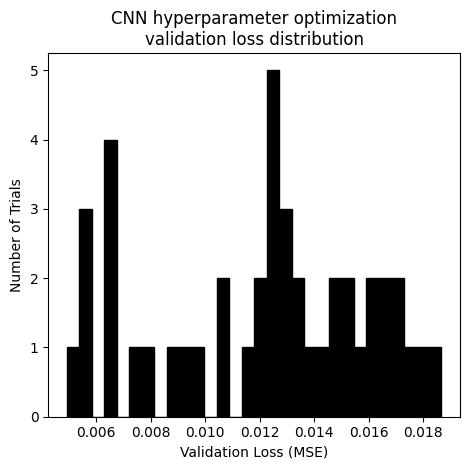

In [4]:
plt.figure(figsize=(config.STD_FIG_WIDTH/1.25, config.STD_FIG_WIDTH/1.25))
plt.title('CNN hyperparameter optimization\nvalidation loss distribution')
plt.hist(
    results_df['value'],
    bins=30,
    color='black',
    edgecolor='black'
)
plt.xlabel('Validation Loss (MSE)')
plt.ylabel('Number of Trials')
# plt.yscale('log')
plt.tight_layout()

# Save the figure
plt.savefig(
    f'{figures_dir}/03.2.1-validation_loss_distribution.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)


### 1.3. Hyperparameter sampling distributions

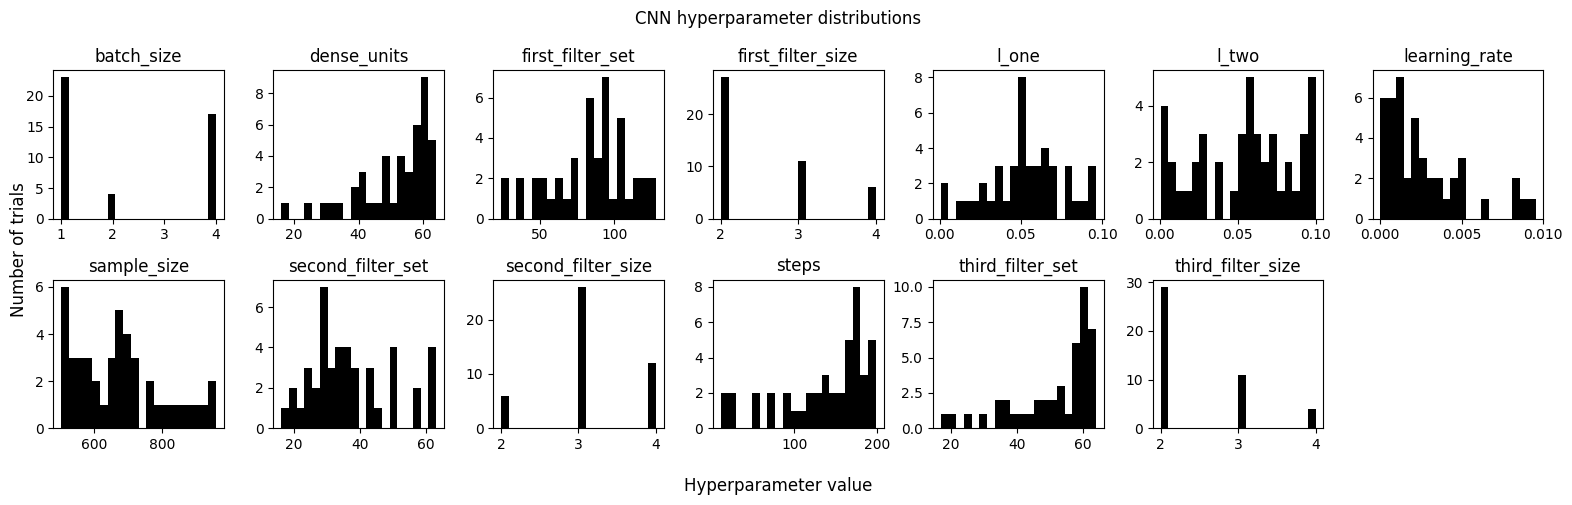

In [5]:
fig, axs = plt.subplots(2, 7, figsize=(16, 5))
axs = axs.flatten()

fig.suptitle('CNN hyperparameter distributions')
fig.supxlabel('Hyperparameter value')
fig.supylabel('Number of trials')

for i, param in enumerate(param_columns):
    axs[i].set_title(param.replace('params_', ''))
    axs[i].hist(
        results_df[param],
        bins=20,
        color='black'
    )

axs[-1].axis('off')  # Turn off the last unused subplot

fig.tight_layout()

# Save the figure
plt.savefig(
    f'{figures_dir}/03.2.2-hyperparameter_distributions.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

### 1.4. Hyperparameter heatmap matrix

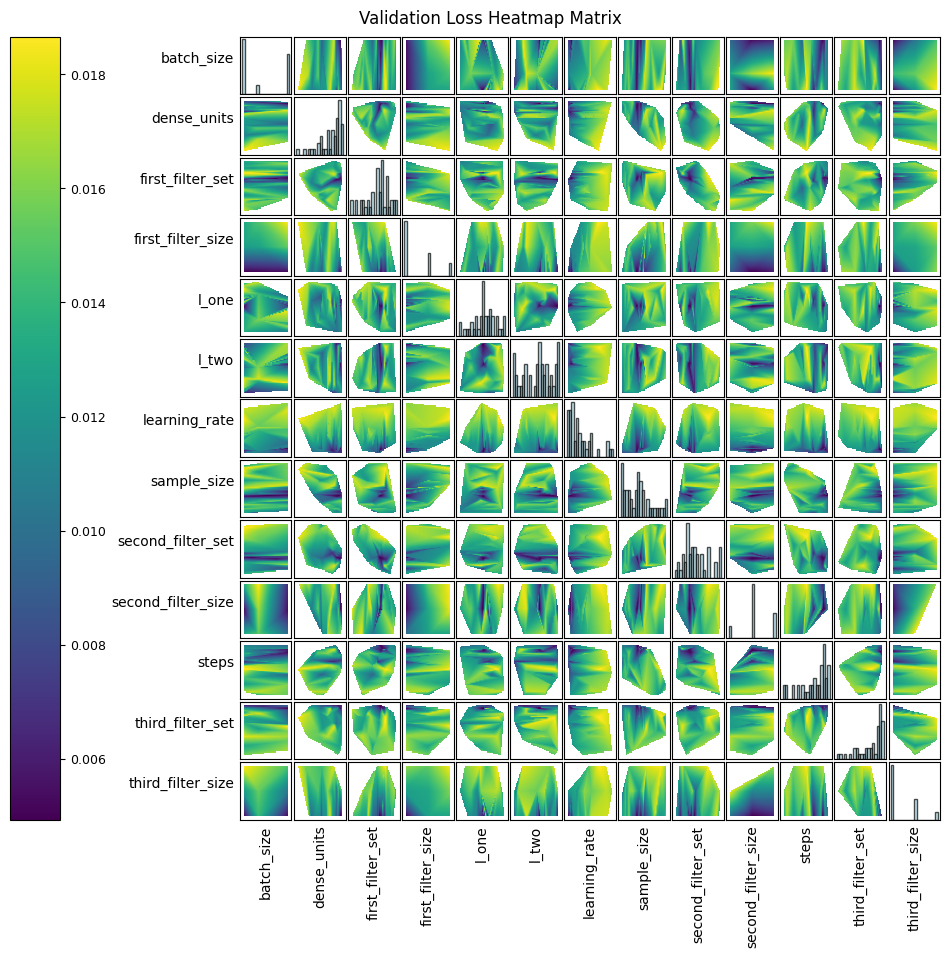

In [6]:
# Create a figure with subplots for the heatmap matrix
n_params = len(param_columns)
fig, axes = plt.subplots(n_params, n_params, figsize=(10, 9))

# Get the range of validation loss values for consistent color scaling
vmin, vmax = results_df['value'].min(), results_df['value'].max()

# Create the heatmap matrix
for i, param_y in enumerate(param_columns):
    for j, param_x in enumerate(param_columns):
        ax = axes[i, j]
        
        if i == j:

            # For diagonal elements, show parameter distribution as histogram
            ax.hist(
                results_df[param_x],
                bins=20,
                alpha=0.7,
                color='lightblue',
                edgecolor='black'
            )
            
            # Configure tick labels and marks: only show for bottom row (x) and first column (y)
            if j == 0:  # Left edge
                ax.set_ylabel(param_y.replace('params_', ''), rotation='horizontal', ha='right')

            if i == n_params - 1:  # Bottom edge
                ax.set_xlabel(param_x.replace('params_', ''), rotation='vertical')

            # Hide all tick labels and marks
            ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False, top=False, right=False)

        else:
            # Create interpolated heatmap of validation loss
            x_data = results_df[param_x].values
            y_data = results_df[param_y].values
            z_data = results_df['value'].values
            
            # Create a regular grid for interpolation
            x_min, x_max = x_data.min(), x_data.max()
            y_min, y_max = y_data.min(), y_data.max()
            
            # Add small margins to avoid edge effects
            x_margin = (x_max - x_min) * 0.05
            y_margin = (y_max - y_min) * 0.05
            
            x_grid = np.linspace(x_min - x_margin, x_max + x_margin, 50)
            y_grid = np.linspace(y_min - y_margin, y_max + y_margin, 50)
            X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
            
            # Interpolate using griddata
            Z_interp = griddata(
                (x_data, y_data), z_data, (X_grid, Y_grid), 
                method='linear', fill_value=np.nan
            )
            
            # Standardize the heatmap using its own min/max values
            z_min_local = np.nanmin(Z_interp)
            z_max_local = np.nanmax(Z_interp)
            
            # Create the interpolated heatmap with individual scaling
            im = ax.imshow(Z_interp, origin='lower', aspect='auto', 
                cmap='viridis', vmin=z_min_local, vmax=z_max_local,
            )
            
            # Set labels only for edge subplots to avoid clutter
            if j == 0:  # Left edge
                ax.set_ylabel(param_y.replace('params_', ''), rotation='horizontal', ha='right')

            if i == n_params - 1:  # Bottom edge
                ax.set_xlabel(param_x.replace('params_', ''), rotation='vertical')

            # Hide all tick labels and marks
            ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False, top=False, right=False)

# Add a single colorbar to the left of the figure showing the global range
# Note: Individual heatmaps are standardized to their own ranges
cbar_ax = fig.add_axes([0.02, 0.08, 0.05, 0.87])  # [left, bottom, width, height]

# Create a dummy mappable for the global colorbar
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=9)

# Adjust layout to make room for the colorbar
plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.08, hspace=0.05, wspace=0.05)

# Add a main title
fig.suptitle(
    'Validation Loss Heatmap Matrix'
)

# Save the figure
plt.savefig(
    f'{figures_dir}/03.2.3-hyperparameter_validation_loss_heatmaps.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

plt.show()

## 2. Long training run

### 2.1. Data preparation 

#### 2.1.1. Load planet list

In [7]:
# Load corrected/extracted data for a sample planet
with h5py.File(f'{config.PROCESSED_DATA_DIRECTORY}/train.h5', 'r') as hdf:
    planet_ids = list(hdf.keys())

print(f'Found {len(planet_ids)} planets in training data.')

Found 1100 planets in training data.


#### 2.1.2. Split planets into training & validation

In [8]:
planet_ids_file = f'{config.METADATA_DIRECTORY}/planet_ids.pkl'

if Path(planet_ids_file).exists():

    with open(planet_ids_file, 'rb') as input_file:
        planet_ids = pickle.load(input_file)
        training_planet_ids = planet_ids['training']
        validation_planet_ids = planet_ids['validation']

    print('Loaded existing training/validation split')

else:
    
    print('Creating new training/validation split')

    random.shuffle(planet_ids)
    training_planet_ids = planet_ids[:len(planet_ids) // 2]
    validation_planet_ids = planet_ids[len(planet_ids) // 2:]

    # Save the training and validation planet IDs
    planet_ids = {
        'training': training_planet_ids,
        'validation': validation_planet_ids
    }

    with open(planet_ids_file, 'wb') as output_file:
        pickle.dump(planet_ids, output_file)

print(f'Training planets: {len(training_planet_ids)}')
print(f'Validation planets: {len(validation_planet_ids)}')

Loaded existing training/validation split
Training planets: 550
Validation planets: 550


### 2.2. Data generator

#### 2.2.1. Data loader function

In [9]:
def data_loader(planet_ids: list, data_file: str, sample_size: int = 100):
    '''Generator that yields signal, spectrum pairs for training/validation/testing.

    Args:
        planet_ids (list): List of planet IDs to include in the generator.
        data_file (str): Path to the HDF5 file containing the data.
        sample_size (int, optional): Number of frames to draw from each planet. Defaults to 100.
    '''

    with h5py.File(data_file, 'r') as hdf:

        while True:
            np.random.shuffle(planet_ids)
            
            for planet_id in planet_ids:

                signal = hdf[planet_id]['signal'][:]
                spectrum = hdf[planet_id]['spectrum'][:]

                indices = random.sample(range(signal.shape[0]), sample_size)
                sample = signal[sorted(indices), :]

                yield sample, spectrum


#### 2.2.2. Prefill the arguments to `data_loader()`

In [10]:
training_data_generator = partial(
    data_loader,
    planet_ids=training_planet_ids,
    data_file=f'{config.PROCESSED_DATA_DIRECTORY}/train.h5',
    sample_size=sample_size
)

validation_data_generator = partial(
    data_loader,
    planet_ids=validation_planet_ids,
    data_file=f'{config.PROCESSED_DATA_DIRECTORY}/train.h5',
    sample_size=sample_size
)

#### 2.2.3. Create TF datasets

In [11]:
training_dataset = tf.data.Dataset.from_generator(
    training_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(sample_size, config.WAVELENGTHS), dtype=tf.float64),
        tf.TensorSpec(shape=(config.WAVELENGTHS), dtype=tf.float64)
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    validation_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(sample_size, config.WAVELENGTHS), dtype=tf.float64),
        tf.TensorSpec(shape=(config.WAVELENGTHS), dtype=tf.float64)
    )
)

### 2.3. CNN

#### 2.3.1. Model definition

In [12]:
def compile_model(
        samples: int=sample_size,
        wavelengths: int=config.WAVELENGTHS,
        learning_rate: float=learning_rate,
        l1: float=l_one,
        l2: float=l_two,
        filter_nums=[first_filter_set, second_filter_set, third_filter_set],
        filter_sizes=[first_filter_size, second_filter_size, third_filter_size]
) -> tf.keras.Model:

    '''Builds the convolutional neural network regression model'''

    # Set-up the L1L2 for the dense layers
    regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)

    # Define the model layers in order
    model = tf.keras.Sequential([
        tf.keras.layers.Input((samples,wavelengths,1)),
        tf.keras.layers.Conv2D(
            filter_nums[0],
            filter_sizes[0],
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filter_nums[1],
            filter_sizes[1],
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filter_nums[2],
            filter_sizes[2],
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            dense_units,
            kernel_regularizer=regularizer,
            activation='relu',
        ),
        tf.keras.layers.Dense(wavelengths, activation='relu')
    ])

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model, specifying the type of loss to use during training and any extra
    # metrics to evaluate
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(name='MSE'),
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='RMSE'),
            tf.keras.metrics.MeanSquaredError(name='MSE')
        ]
    )

    return model

In [13]:
model = compile_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 657, 283, 89)      445       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 328, 141, 89)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 328, 141, 32)      25664     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 164, 70, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 164, 70, 64)       8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 82, 35, 64)       0

#### 2.3.2. Training

In [ ]:
total_ksteps = int((epochs * steps) / 1000)
model_save_file = f'{config.MODELS_DIRECTORY}/optimized_cnn-{total_ksteps}ksteps.keras'
training_results_save_file = f'{config.MODELS_DIRECTORY}/training_results-{total_ksteps}ksteps.pkl'

if Path(model_save_file).exists() and Path(training_results_save_file).exists():

    print(f'Found existing model for {total_ksteps} ksteps, skipping training.')

    # Load the existing model
    model = tf.keras.models.load_model(model_save_file)

    # Load existing training results
    with open(training_results_save_file, 'rb') as input_file:
        training_results = pickle.load(input_file)

else:

  print(f'Training model for {total_ksteps} ksteps')
  start_time = time.time()

  training_results = model.fit(
    training_dataset.batch(batch_size),
    validation_data=validation_dataset.batch(batch_size),
    epochs=epochs,
    steps_per_epoch=steps,
    validation_steps=steps,
    verbose=1
  )

  print(f'Training complete in {(time.time() - start_time)/60:.1f} minutes')
  model.save(model_save_file)

  with open(training_results_save_file, 'wb') as output_file:
      pickle.dump(training_results, output_file)

Training model for 398 ksteps
Epoch 1/2000
199/199 [==============================] - 11s 32ms/step - loss: 84.6981 - RMSE: 0.0138 - MSE: 1.9166e-04 - val_loss: 27.8404 - val_RMSE: 0.0128 - val_MSE: 1.6492e-04
Epoch 2/2000
199/199 [==============================] - 6s 30ms/step - loss: 27.9801 - RMSE: 0.0130 - MSE: 1.6803e-04 - val_loss: 27.5920 - val_RMSE: 0.0143 - val_MSE: 2.0348e-04
Epoch 3/2000
199/199 [==============================] - 6s 29ms/step - loss: 27.6586 - RMSE: 0.0122 - MSE: 1.4796e-04 - val_loss: 27.0255 - val_RMSE: 0.0133 - val_MSE: 1.7722e-04
Epoch 4/2000
199/199 [==============================] - 6s 29ms/step - loss: 27.3985 - RMSE: 0.0119 - MSE: 1.4143e-04 - val_loss: 26.9153 - val_RMSE: 0.0123 - val_MSE: 1.5077e-04
Epoch 5/2000
199/199 [==============================] - 6s 29ms/step - loss: 27.1795 - RMSE: 0.0131 - MSE: 1.7061e-04 - val_loss: 27.2970 - val_RMSE: 0.0135 - val_MSE: 1.8243e-04
Epoch 6/2000
199/199 [==============================] - 6s 31ms/step - los

In [ ]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,3, figsize=(12,4))

# Add the main title
fig.suptitle('CNN training curves', size='large')

# Plot training and validation loss
axs[0].set_title('Training loss (mean squared error)')
axs[0].plot(np.array(training_results.history['loss']), alpha=0.5, label='Training')
axs[0].plot(np.array(training_results.history['val_loss']), alpha=0.5, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('loss')
axs[0].set_ylim(21, 25)
# axs[0].set_yscale('log')
axs[0].legend(loc='upper right')

# Plot training and validation MSE
axs[1].set_title('Mean squared error')
axs[1].plot(training_results.history['MSE'], alpha=0.5, label='Training')
axs[1].plot(training_results.history['val_MSE'], alpha=0.5, label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MSE')
# axs[1].set_ylim(top=0.014)
axs[1].set_yscale('log')

# Plot training and validation RMSE
axs[2].set_title('Root mean squared error')
axs[2].plot(training_results.history['RMSE'], alpha=0.5, label='Training')
axs[2].plot(training_results.history['val_RMSE'], alpha=0.5, label='Validation')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('RMSE')
# axs[2].set_ylim(top=0.014)
axs[2].set_yscale('log')

# Show the plot
fig.tight_layout()
fig.savefig(
    f'{figures_dir}/03.2.4-training_curves_{total_ksteps}ksteps.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

## 3. Model evaluation (validation set)

### 3.1. Prediction dataset

In [ ]:
def prediction_data_loader(planet_ids: list, data_file: str, sample_size: int = 100, n_samples: int = 10):
    '''Generator that yields signal, spectrum pairs for training/validation/testing.

    Args:
        planet_ids (list): List of planet IDs to include in the generator.
        data_file (str): Path to the HDF5 file containing the data.
        sample_size (int, optional): Number of frames to draw from each planet. Defaults to 100.
    '''

    with h5py.File(data_file, 'r') as hdf:

        while True:
            
            for planet_id in planet_ids:

                signal = hdf[planet_id]['signal'][:]

                samples = []
                spectra = []

                for _ in range(n_samples):

                    indices = random.sample(range(signal.shape[0]), sample_size)
                    samples.append(signal[sorted(indices), :])
                    spectra.append(hdf[planet_id]['spectrum'][:])

                yield np.array(samples), np.array(spectra)


In [ ]:
prediction_data_generator = partial(
    prediction_data_loader,
    planet_ids=validation_planet_ids,
    data_file=f'{config.PROCESSED_DATA_DIRECTORY}/train.h5',
    sample_size=sample_size,
    n_samples=samples
)

In [ ]:
prediction_dataset = tf.data.Dataset.from_generator(
    prediction_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(samples, sample_size, config.WAVELENGTHS), dtype=tf.float64),
        tf.TensorSpec(shape=(samples, config.WAVELENGTHS), dtype=tf.float64)
    )
)

In [ ]:
validation_data = prediction_dataset.take(planets)

signals = np.array([element[0].numpy() for element in validation_data])
spectra = np.array([element[1].numpy() for element in validation_data])

print(f'Signals shape: {signals.shape}')
print(f'Spectra shape: {spectra.shape}')

### 3.2. Predictions

In [ ]:
spectrum_predictions = []

for planet in signals:
    spectrum_predictions.append(model.predict(planet, batch_size=samples, verbose=0))

spectrum_predictions = np.array(spectrum_predictions)
spectrum_predictions_avg = np.mean(spectrum_predictions, axis=1).flatten()
spectrum_predictions = spectrum_predictions.flatten()
reference_spectra = spectra[:,0,:].flatten()
spectra = spectra.flatten()

### 3.3. Plot

In [ ]:
plt.title('Predicted vs true spectral signals')
plt.scatter(spectra, spectrum_predictions, s=10, alpha=0.5, color='black', label='Sample predictions')
plt.scatter(reference_spectra, spectrum_predictions_avg, s=2.5, alpha=0.5, color='red', label='Averaged prediction')
plt.xlabel('True spectral signal')
plt.ylabel('Predicted spectral signal')
plt.legend(loc='best', markerscale=2)

plt.savefig(
    f'{figures_dir}/03.2.5-predicted_vs_true_spectra.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

plt.show()